In [2]:
# ============================================================
# SEGMENT-WISE FORECASTING MODEL (FINAL CODE)
# Uses segment history (Locality+City+Type) + time (future quarter/year)
# Predicts: Average Price
# Target transform: PowerTransformer (Yeo-Johnson)  ✅ (Option 1)
#
# This code prints + plots at key points for understanding.
# Paste into Google Colab (single notebook cell is fine).
# ============================================================

# -----------------------------
# 0) Imports
# -----------------------------
import numpy as np                              # math + arrays
import pandas as pd                             # dataframe operations

import matplotlib.pyplot as plt                 # plotting
import seaborn as sns                           # nicer plots
from sklearn.model_selection import train_test_split  # (we will do time split manually too)
from sklearn.preprocessing import OneHotEncoder       # categorical encoding
from sklearn.preprocessing import StandardScaler      # numeric scaling
from sklearn.preprocessing import PowerTransformer    # best tuned transform for skew

from sklearn.compose import ColumnTransformer         # column-wise preprocess
from sklearn.pipeline import Pipeline                 # end-to-end pipeline

from sklearn.ensemble import RandomForestRegressor    # one simple model (robust)
from sklearn.metrics import r2_score, mean_squared_error  # evaluation metrics

import joblib                                    # saving pretrained artifacts


In [3]:
# -----------------------------
# 1) Load dataset
# -----------------------------
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/ML Project/Profitx Project/clean.csv")   # read your CSV from Colab directory

print("✅ Loaded data")
print("Shape:", df.shape)                        # rows, cols
print("Columns:", list(df.columns))              # column names
print("\nPreview:")
print(df.head(3))                                # preview first rows


✅ Loaded data
Shape: (6416, 11)
Columns: ['Locality', 'City', 'Type', 'Months', 'Year', 'Price Range', 'Min_Price', 'Max_Price', 'Average Price', 'Q-o-Q', 'QOQ_missing']

Preview:
       Locality    City                                  Type   Months  Year  \
0  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  Jul-Sep  2024   
1  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  Apr-Jun  2024   
2  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  Jan-Mar  2024   

   Price Range  Min_Price  Max_Price  Average Price  Q-o-Q  QOQ_missing  
0  16266-29066      16266      29066        22666.0    6.0            0  
1  15531-27163      15531      27163        21347.0    1.0            0  
2  15841-27342      15841      27342        21591.0    6.0            0  


In [4]:
# -----------------------------
# 2) Basic EDA checks
# -----------------------------
print("\n--- Missing values per column ---")
print(df.isna().sum())                           # missing count

print("\n--- Duplicate rows ---")
print("Duplicates:", df.duplicated().sum())      # duplicates count

print("\n--- Target stats (Average Price) ---")
print(df["Average Price"].describe())            # quick stats



--- Missing values per column ---
Locality         0
City             0
Type             0
Months           0
Year             0
Price Range      0
Min_Price        0
Max_Price        0
Average Price    0
Q-o-Q            0
QOQ_missing      0
dtype: int64

--- Duplicate rows ---
Duplicates: 0

--- Target stats (Average Price) ---
count     6416.000000
mean     21871.400639
std      11688.988626
min       1450.000000
25%      15699.750000
50%      19207.000000
75%      27507.500000
max      68164.000000
Name: Average Price, dtype: float64


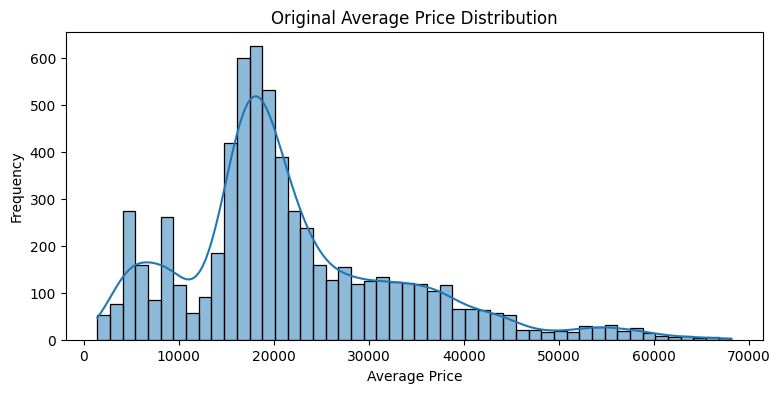

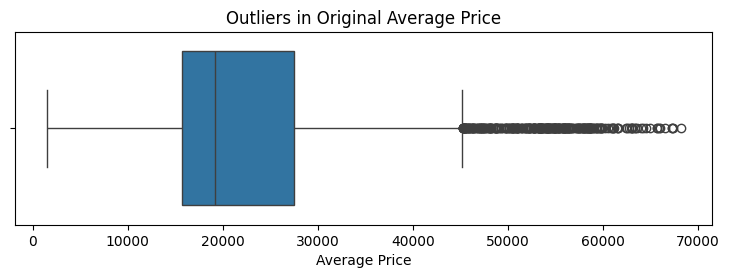

In [5]:
# -----------------------------
# 3) Visualize original target distribution
# -----------------------------
plt.figure(figsize=(9,4))
sns.histplot(df["Average Price"], bins=50, kde=True)
plt.title("Original Average Price Distribution")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(9,2.5))
sns.boxplot(x=df["Average Price"])
plt.title("Outliers in Original Average Price")
plt.show()


In [6]:
# -----------------------------
# 4) Quarter/Months handling (IMPORTANT)
# We need to convert Months -> quarter_id (1..4) in a robust way.
# Some segments might miss quarters/years; that's okay.
# -----------------------------
print("\nUnique Months values in your dataset:")
print(df["Months"].dropna().unique())            # show all labels to confirm mapping

# Common mapping for Mumbai-style quarters
# If your Months values differ, we will detect unmapped values and stop with a helpful print.
quarter_map = {
    "Jan-Mar": 1, "Jan - Mar": 1, "JAN-MAR": 1, "Q1": 1, "q1": 1, "1": 1,
    "Apr-Jun": 2, "Apr - Jun": 2, "APR-JUN": 2, "Q2": 2, "q2": 2, "2": 2,
    "Jul-Sep": 3, "Jul - Sep": 3, "JUL-SEP": 3, "Q3": 3, "q3": 3, "3": 3,
    "Oct-Dec": 4, "Oct - Dec": 4, "OCT-DEC": 4, "Q4": 4, "q4": 4, "4": 4,
}
# Convert Months -> quarter_id using mapping (unknown become NaN)
df["quarter_id"] = df["Months"].astype(str).map(quarter_map)

# Check if any Months labels failed mapping
unmapped = df.loc[df["quarter_id"].isna(), "Months"].unique()

if len(unmapped) > 0:
    print("\n❌ Unmapped Months labels found:", unmapped)
    print("Fix quarter_map based on the printed unique Months values above, then rerun.")
    raise ValueError("Months mapping failed. Update quarter_map and rerun.")

# Make quarter_id integer
df["quarter_id"] = df["quarter_id"].astype(int)

print("\n✅ Months successfully mapped to quarter_id.")
print(df[["Months", "quarter_id"]].drop_duplicates().sort_values("quarter_id").head(10))



Unique Months values in your dataset:
['Jul-Sep' 'Apr-Jun' 'Jan-Mar' 'Oct-Dec']

✅ Months successfully mapped to quarter_id.
    Months  quarter_id
2  Jan-Mar           1
1  Apr-Jun           2
0  Jul-Sep           3
3  Oct-Dec           4


In [7]:
# -----------------------------
# 5) Create a time index
# time_idx = year*4 + quarter_id
# This is just "time position" so model knows future distance + seasonality.
# -----------------------------
df["Year"] = df["Year"].astype(int)              # ensure int year
df["time_idx"] = df["Year"] * 4 + df["quarter_id"]  # continuous time counter

print("\n✅ time_idx created.")
print(df[["Year", "Months", "quarter_id", "time_idx"]].head(5))


✅ time_idx created.
   Year   Months  quarter_id  time_idx
0  2024  Jul-Sep           3      8099
1  2024  Apr-Jun           2      8098
2  2024  Jan-Mar           1      8097
3  2023  Oct-Dec           4      8096
4  2023  Jul-Sep           3      8095


In [8]:
# -----------------------------
# 6) Sort by segment and time
# Segment = (Locality, City, Type)
# -----------------------------
SEG_COLS = ["Locality", "City", "Type"]          # segment definition

df = df.sort_values(SEG_COLS + ["time_idx"]).reset_index(drop=True)

print("\n✅ Data sorted by segment + time.")
print(df[SEG_COLS + ["Year", "Months", "time_idx", "Average Price"]].head(5))


✅ Data sorted by segment + time.
       Locality    City                                  Type  Year   Months  \
0  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2018  Jul-Sep   
1  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2018  Oct-Dec   
2  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Jan-Mar   
3  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Apr-Jun   
4  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Jul-Sep   

   time_idx  Average Price  
0      8075        15500.0  
1      8076        15600.0  
2      8077        15700.0  
3      8078        15800.0  
4      8079        15900.0  


In [9]:
# -----------------------------
# 7) Feature Engineering from history (NO LEAKAGE)
# Key: Every feature must use ONLY PAST records of same segment.
# Missing quarters/years are okay: we use past available observations.
# -----------------------------
def add_history_features(seg_df: pd.DataFrame) -> pd.DataFrame:
    """
    seg_df: one segment's rows sorted by time_idx.
    We create lag, rolling, and seasonal features using shift(1).
    shift(1) ensures we never use the current row's target or future info.
    """
    seg_df = seg_df.copy()

    # ---- Lag features (previous available observation) ----
    seg_df["lag_avg_1"] = seg_df["Average Price"].shift(1)   # previous avg
    seg_df["lag_min_1"] = seg_df["Min_Price"].shift(1)       # previous min
    seg_df["lag_max_1"] = seg_df["Max_Price"].shift(1)       # previous max
    seg_df["lag_qoq_1"] = seg_df["Q-o-Q"].shift(1)           # previous QoQ

    # ---- Rolling stats over last 4 observations (not necessarily consecutive quarters) ----
    seg_df["roll_avg_mean_4"] = seg_df["Average Price"].rolling(4).mean().shift(1)
    seg_df["roll_avg_std_4"]  = seg_df["Average Price"].rolling(4).std().shift(1)
    seg_df["roll_qoq_mean_4"] = seg_df["Q-o-Q"].rolling(4).mean().shift(1)
    # ---- Seasonal features: "what usually happens in this quarter_id for this segment" ----
    # expanding().mean() computes mean using all available past values within that quarter_id
    # shift(1) prevents using the current row
    seg_df["seasonal_avg_qtr"] = (
        seg_df.groupby("quarter_id")["Average Price"]
              .expanding().mean().shift(1)
              .reset_index(level=0, drop=True)
    )

    seg_df["seasonal_qoq_qtr"] = (
        seg_df.groupby("quarter_id")["Q-o-Q"]
              .expanding().mean().shift(1)
              .reset_index(level=0, drop=True)
    )

    # ---- History length: how many past observations exist before this row ----
    seg_df["history_len"] = np.arange(len(seg_df))           # 0,1,2,...

    return seg_df


# Apply to every segment (Locality+City+Type)
df_feat = df.groupby(SEG_COLS, group_keys=False).apply(add_history_features)

print("\n✅ History features created.")
print(df_feat[SEG_COLS + ["Year", "Months", "Average Price", "lag_avg_1", "roll_avg_mean_4", "seasonal_avg_qtr"]].head(8))




✅ History features created.
       Locality    City                                  Type  Year   Months  \
0  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2018  Jul-Sep   
1  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2018  Oct-Dec   
2  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Jan-Mar   
3  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Apr-Jun   
4  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Jul-Sep   
5  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2019  Oct-Dec   
6  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2020  Jan-Mar   
7  90 Feet Road  Mumbai  Residential - Multi Storey Apartment  2020  Apr-Jun   

   Average Price  lag_avg_1  roll_avg_mean_4  seasonal_avg_qtr  
0        15500.0        NaN              NaN      17766.166667  
1        15600.0    15500.0              NaN      17838.000000  
2        15700.0    15600.0              NaN           

/tmp/ipython-input-525474296.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df.groupby(SEG_COLS, group_keys=False).apply(add_history_features)


In [10]:
# -----------------------------
# 8) Drop rows that don't have enough history
# Why: first rows of each segment won't have lag/rolling values.
# This is expected and NOT an error.
# -----------------------------
before = len(df_feat)                                             # count before dropping
df_feat = df_feat.dropna(subset=["lag_avg_1", "roll_avg_mean_4", "seasonal_avg_qtr"]).copy()
after = len(df_feat)                                              # count after dropping

print(f"\n✅ Dropped rows with insufficient history: {before - after}")
print("Remaining rows for training:", after)


✅ Dropped rows with insufficient history: 1253
Remaining rows for training: 5163


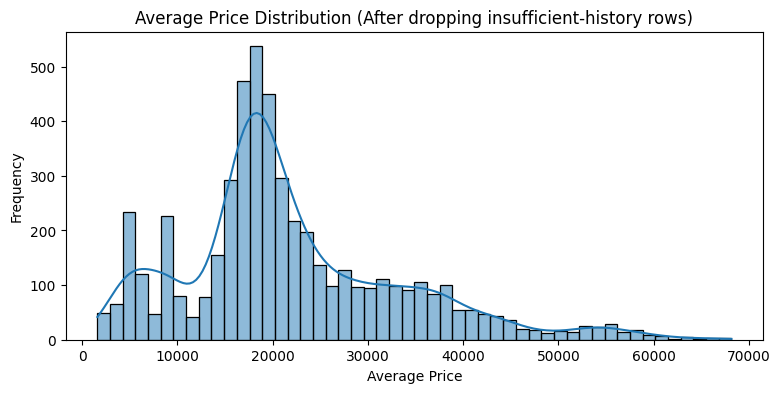

In [11]:
# -----------------------------
# 9) Visualize distributions AFTER feature engineering
# (Still same target, but now dataset is more "forecast-ready")
# -----------------------------
plt.figure(figsize=(9,4))
sns.histplot(df_feat["Average Price"], bins=50, kde=True)
plt.title("Average Price Distribution (After dropping insufficient-history rows)")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.show()


In [12]:
# -----------------------------
# 10) Define training features (X) and target (y)
# User inputs: Locality, City, Type, future Months/Year (represented as quarter_id + Year + time_idx)
# History features: lag/rolling/seasonal/QoQ info
# -----------------------------
feature_cols = [
    # segment identity (categorical)
    "Locality", "City", "Type",

    # time position (future quarter/year will be here at inference)
    "quarter_id", "Year", "time_idx",

    # history summaries (built from past values only)
    "lag_avg_1", "lag_min_1", "lag_max_1", "lag_qoq_1",
    "roll_avg_mean_4", "roll_avg_std_4", "roll_qoq_mean_4",
    "seasonal_avg_qtr", "seasonal_qoq_qtr",
    "history_len"
]

target_col = "Average Price"  # we want to forecast average price

X = df_feat[feature_cols]     # features
y = df_feat[target_col].astype(float)  # target

print("\n✅ Feature columns used:")
print(feature_cols)
print("\nX preview:")
print(X.head(3))


✅ Feature columns used:
['Locality', 'City', 'Type', 'quarter_id', 'Year', 'time_idx', 'lag_avg_1', 'lag_min_1', 'lag_max_1', 'lag_qoq_1', 'roll_avg_mean_4', 'roll_avg_std_4', 'roll_qoq_mean_4', 'seasonal_avg_qtr', 'seasonal_qoq_qtr', 'history_len']

X preview:
       Locality    City                                  Type  quarter_id  \
4  90 Feet Road  Mumbai  Residential - Multi Storey Apartment           3   
5  90 Feet Road  Mumbai  Residential - Multi Storey Apartment           4   
6  90 Feet Road  Mumbai  Residential - Multi Storey Apartment           1   

   Year  time_idx  lag_avg_1  lag_min_1  lag_max_1  lag_qoq_1  \
4  2019      8079    15800.0    11600.0    20000.0        1.0   
5  2019      8080    15900.0    11700.0    20100.0        1.0   
6  2020      8081    16000.0    11800.0    20200.0        1.0   

   roll_avg_mean_4  roll_avg_std_4  roll_qoq_mean_4  seasonal_avg_qtr  \
4          15650.0      129.099445              1.0           15500.0   
5          15750.0   


✅ Time-based split done.
Cutoff time_idx: 8096.0
Train rows: 4341 Test rows: 822

✅ PowerTransformer fitted on TRAIN target only.
Transformed target stats (train):
count    4.341000e+03
mean    -1.145773e-16
std      1.000115e+00
min     -2.668308e+00
25%     -3.985149e-01
50%     -7.709805e-02
75%      6.156102e-01
max      2.871449e+00
dtype: float64


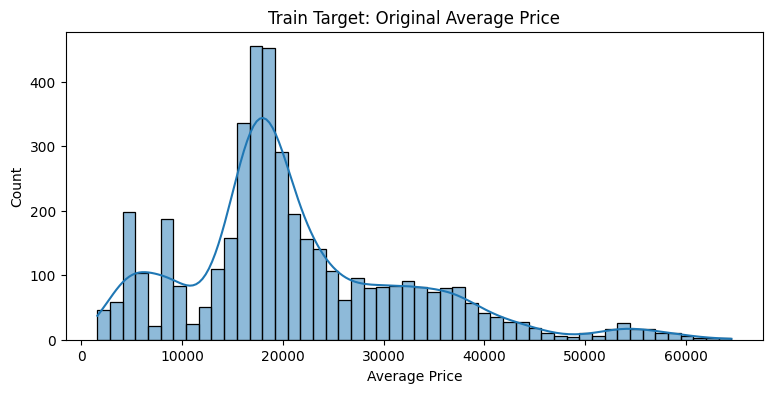

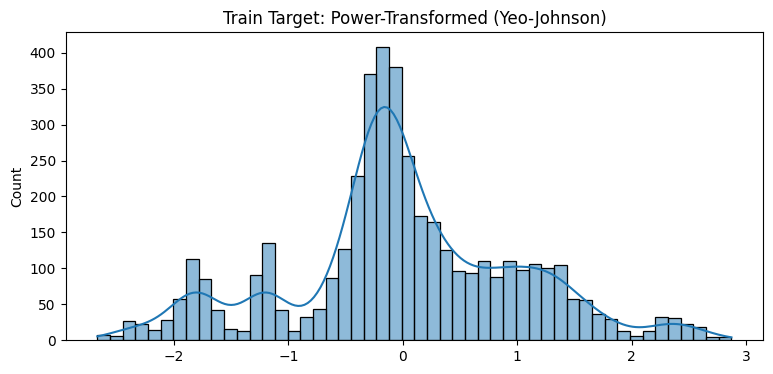

In [13]:
# -----------------------------
# 11) Target transform (Option 1): PowerTransformer
# We fit transformer on TRAIN target ONLY (avoid leakage)
# We'll do time-based split next.
# -----------------------------
# Create a cutoff for time-based split:
# Train = older data, Test = newer data (more realistic forecasting evaluation)
cutoff = df_feat["time_idx"].quantile(0.8)      # 80% oldest time points for training (approx)

train_mask = df_feat["time_idx"] <= cutoff     # boolean mask for train
test_mask  = df_feat["time_idx"] > cutoff      # boolean mask for test

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()

X_test  = X.loc[test_mask].copy()
y_test  = y.loc[test_mask].copy()

print("\n✅ Time-based split done.")
print("Cutoff time_idx:", cutoff)
print("Train rows:", len(X_train), "Test rows:", len(X_test))


# Fit power transformer on training target ONLY
pt = PowerTransformer(method="yeo-johnson", standardize=True)

y_train_t = pt.fit_transform(y_train.to_numpy().reshape(-1,1)).ravel()   # transformed train target
y_test_t  = pt.transform(y_test.to_numpy().reshape(-1,1)).ravel()        # transformed test target (same transformer)

print("\n✅ PowerTransformer fitted on TRAIN target only.")
print("Transformed target stats (train):")
print(pd.Series(y_train_t).describe())

# Plot comparison: original vs transformed target (train)
plt.figure(figsize=(9,4))
sns.histplot(y_train, bins=50, kde=True)
plt.title("Train Target: Original Average Price")
plt.show()

plt.figure(figsize=(9,4))
sns.histplot(y_train_t, bins=50, kde=True)
plt.title("Train Target: Power-Transformed (Yeo-Johnson)")
plt.show()

In [14]:
# -----------------------------
# 12) Preprocessing for X (categorical + numeric)
# -----------------------------
cat_cols = ["Locality", "City", "Type"]                    # categorical
num_cols = [c for c in feature_cols if c not in cat_cols]  # numeric

# Convert categorical to one-hot; numeric to standardized values
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)


In [15]:
# -----------------------------
# 13) Model (ONE model only): Random Forest
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=400,          # number of trees (more trees = more stable)
    random_state=42,           # reproducibility
    n_jobs=-1                  # use all CPU cores
)

# Build pipeline: preprocess -> model
model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("rf", rf)
    ]
)

print("\n✅ Model pipeline created (preprocess + RandomForest).")



✅ Model pipeline created (preprocess + RandomForest).


In [16]:
# -----------------------------
# 14) Train the model on transformed target
# -----------------------------
model.fit(X_train, y_train_t)
print("\n✅ Model trained on POWER-transformed target.")


✅ Model trained on POWER-transformed target.


In [17]:
# -----------------------------
# 15) Predict on test set (transformed space) then invert to original price
# -----------------------------
pred_test_t = model.predict(X_test)                                   # predictions in transformed scale
pred_test_price = pt.inverse_transform(pred_test_t.reshape(-1,1)).ravel()  # back to real price

# Evaluate on ORIGINAL price scale
r2 = r2_score(y_test, pred_test_price)
rmse = np.sqrt(mean_squared_error(y_test, pred_test_price))
rmse_percent = (rmse / y_test.mean()) * 100

print("\n📌 Model Performance (Original Price Scale)")
print("R²:", r2)
print("RMSE:", rmse)
print("RMSE %:", rmse_percent)



📌 Model Performance (Original Price Scale)
R²: 0.9860129715073955
RMSE: 1530.1983201300786
RMSE %: 6.018212770630647


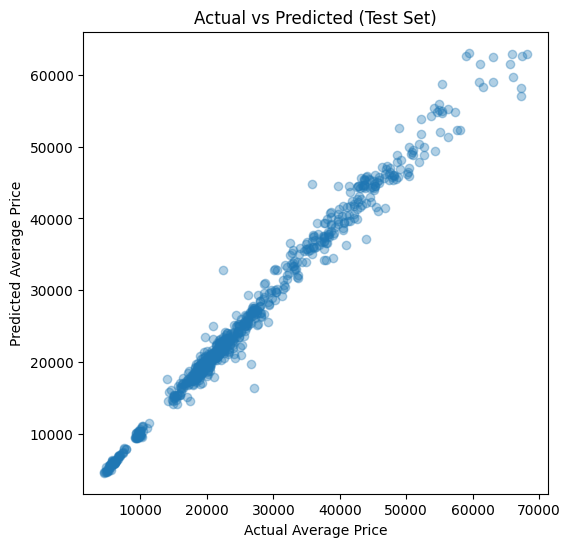

In [18]:
# -----------------------------
# 16) Plot Actual vs Predicted (test)
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test_price, alpha=0.35)
plt.xlabel("Actual Average Price")
plt.ylabel("Predicted Average Price")
plt.title("Actual vs Predicted (Test Set)")
plt.show()



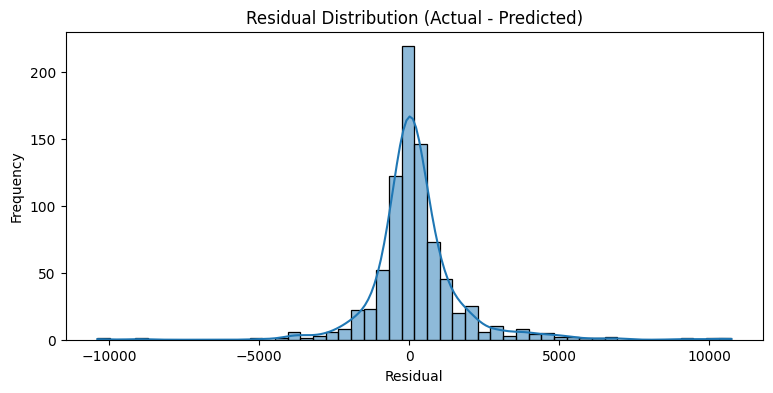


Residual summary:
count      822.000000
mean       221.330567
std       1515.028722
min     -10392.033151
25%       -352.667452
50%         82.487704
75%        624.428852
max      10738.649238
dtype: float64


In [19]:
# -----------------------------
# 17) Residual distribution plot (test)
# Residual = actual - predicted
# -----------------------------
residuals = y_test.to_numpy() - pred_test_price

plt.figure(figsize=(9,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

print("\nResidual summary:")
print(pd.Series(residuals).describe())

# Overfitt Tests


TRAIN -> R²: 0.9975961160808509  RMSE: 549.6834021268937
TEST  -> R²: 0.9860129715073955  RMSE: 1530.1983201300784


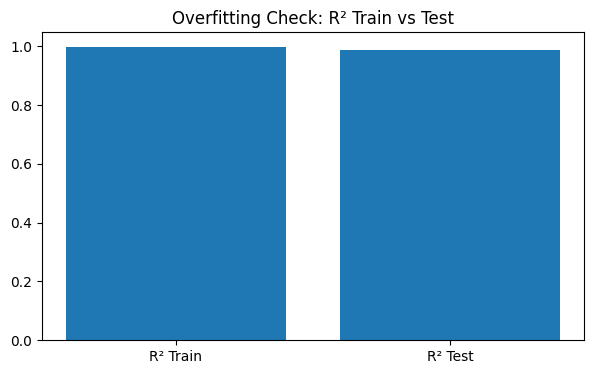

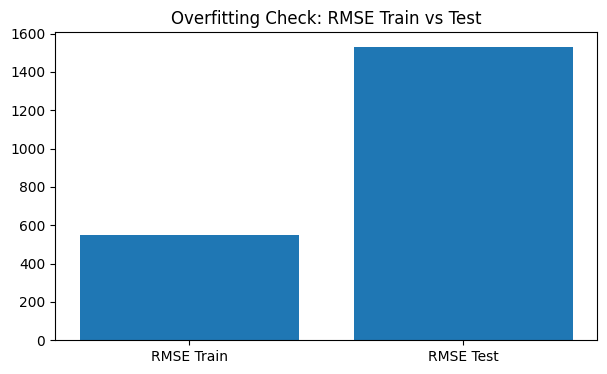

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# ---- Predict on train (transformed) then invert to original price ----
pred_train_t = model.predict(X_train)
pred_train = pt.inverse_transform(pred_train_t.reshape(-1,1)).ravel()

# ---- Predict on test (transformed) then invert to original price ----
pred_test_t = model.predict(X_test)
pred_test = pt.inverse_transform(pred_test_t.reshape(-1,1)).ravel()

# ---- Metrics (original scale) ----
r2_train = r2_score(y_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

r2_test = r2_score(y_test, pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print("TRAIN -> R²:", r2_train, " RMSE:", rmse_train)
print("TEST  -> R²:", r2_test,  " RMSE:", rmse_test)

# ---- Plot train vs test metrics ----
plt.figure(figsize=(7,4))
plt.bar(["R² Train", "R² Test"], [r2_train, r2_test])
plt.title("Overfitting Check: R² Train vs Test")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(["RMSE Train", "RMSE Test"], [rmse_train, rmse_test])
plt.title("Overfitting Check: RMSE Train vs Test")
plt.show()


# Underfitting Check

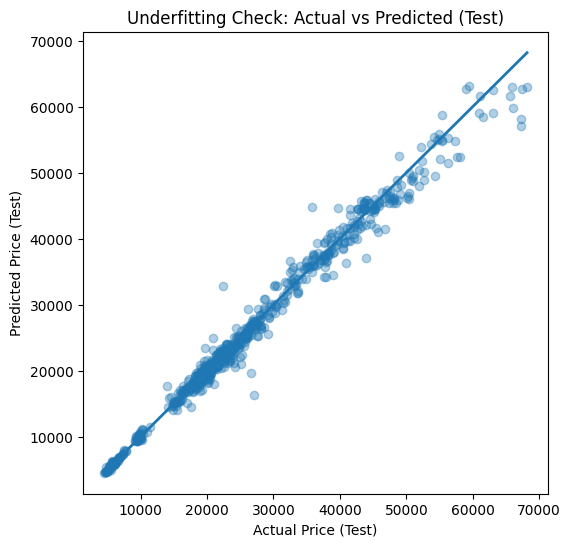

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Ideal line endpoints
mn = min(y_test.min(), pred_test.min())
mx = max(y_test.max(), pred_test.max())

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test, alpha=0.35)
plt.plot([mn, mx], [mn, mx], linewidth=2)  # ideal y=x line
plt.xlabel("Actual Price (Test)")
plt.ylabel("Predicted Price (Test)")
plt.title("Underfitting Check: Actual vs Predicted (Test)")
plt.show()


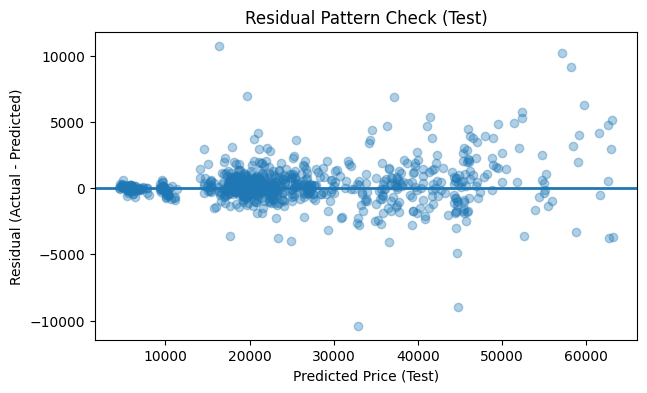

In [22]:
residuals = y_test.to_numpy() - pred_test

plt.figure(figsize=(7,4))
plt.scatter(pred_test, residuals, alpha=0.35)
plt.axhline(0, linewidth=2)
plt.xlabel("Predicted Price (Test)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Pattern Check (Test)")
plt.show()


In [23]:
# -----------------------------
# 18) Save pretrained artifact (model + target transformer + schema)
# This is what FastAPI will load later.
# -----------------------------
artifact = {
    "model": model,                              # preprocess + RF
    "target_transformer": pt,                    # PowerTransformer for y
    "feature_cols": feature_cols,                # required input schema
    "cat_cols": cat_cols,                        # for reference
    "num_cols": num_cols,                        # for reference
    "quarter_map": quarter_map                   # mapping used in training
}

joblib.dump(artifact, "segment_forecast_model.pkl")
print("\n✅ Saved pretrained artifact: segment_forecast_model.pkl")


✅ Saved pretrained artifact: segment_forecast_model.pkl


## Normal Way

In [ ]:
import numpy as np
import pandas as pd
import joblib
import re

# -----------------------------
# Load pretrained artifact
# -----------------------------
artifact = joblib.load("/content/segment_forecast_model.pkl")
model = artifact["model"]
pt = artifact["target_transformer"]
feature_cols = artifact["feature_cols"]
quarter_map = artifact.get("quarter_map", {}).copy()
quarter_map.update({"April-June": 2})  # alias fix

print("✅ Loaded pretrained model.")

# -----------------------------
# Load historical dataset
# -----------------------------
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/ML Project/Profitx Project/clean.csv")
print("✅ Loaded historical dataset.")

# -----------------------------
# Helper: normalize strings to avoid mismatches
# -----------------------------
def norm(s):
    s = str(s)
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s.lower()

# Create normalized columns
df["Locality_n"] = df["Locality"].apply(norm)
df["City_n"]     = df["City"].apply(norm)
df["Type_n"]     = df["Type"].apply(norm)
df["Months_n"]   = df["Months"].apply(norm)

# Normalized quarter map
quarter_map_n = {norm(k): v for k, v in quarter_map.items()}

# Map months -> quarter_id
df["quarter_id"] = df["Months_n"].map(quarter_map_n)

# Ensure numeric columns (coerce bad values to NaN)
for col in ["Year", "Average Price", "Min_Price", "Max_Price", "Q-o-Q"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Time index (keep NaN quarter_id as NaN; we'll drop them when needed)
df["time_idx"] = df["Year"] * 4 + df["quarter_id"]

# Sort
SEG_COLS_N = ["Locality_n", "City_n", "Type_n"]
df = df.sort_values(SEG_COLS_N + ["time_idx"]).reset_index(drop=True)

# -----------------------------
# Unified predictor (your logic)
# 1) If exact row exists -> return CSV Average Price
# 2) Else -> predict (works for missing past or future)
# -----------------------------
def predict_unified(locality, city, prop_type, months, year, min_history=5):
    # Normalize user inputs
    locality_n = norm(locality)
    city_n     = norm(city)
    type_n     = norm(prop_type)
    months_n   = norm(months)

    # Convert months -> quarter_id
    qid = quarter_map_n.get(months_n, None)
    if qid is None:
        raise ValueError(
            f"Invalid months '{months}'. Try: Jan-Mar, Apr-Jun/April-June, Jul-Sep, Oct-Dec"
        )

    year = int(year)
    req_t = year * 4 + int(qid)

    # Pull this segment history
    seg = df[
        (df["Locality_n"] == locality_n) &
        (df["City_n"] == city_n) &
        (df["Type_n"] == type_n)
    ].copy()

    if len(seg) == 0:
        candidates = df[df["City_n"] == city_n][["Locality", "City", "Type"]].drop_duplicates().head(15)
        raise ValueError(
            f"Segment not found for (Locality={locality}, City={city}, Type={prop_type}).\n"
            f"Some candidates in same city:\n{candidates.to_string(index=False)}"
        )

    # Drop rows whose Months couldn't be mapped
    seg = seg.dropna(subset=["quarter_id"]).sort_values("time_idx")

    # ---- RULE 1: If exact row exists in CSV -> return lookup ----
    exact = seg[(seg["Year"] == year) & (seg["quarter_id"] == int(qid))]
    if len(exact) > 0 and pd.notna(exact["Average Price"].iloc[0]):
        actual_val = float(exact["Average Price"].iloc[0])
        print("\n📄 LOOKUP MODE (exact row found in CSV)")
        print("Average Price:", actual_val)
        return actual_val

    # ---- RULE 2: Otherwise predict using model (past missing or future) ----
    past = seg[seg["time_idx"] < req_t].copy()

    if len(past) < min_history:
        raise ValueError(
            f"Not enough past data to predict (need >= {min_history} rows, have {len(past)})."
        )

    # Take last known valid row (must have required numeric fields)
    needed = ["Average Price", "Min_Price", "Max_Price", "Q-o-Q"]
    past_valid = past.dropna(subset=needed).copy()
    if len(past_valid) == 0:
        raise ValueError("Past history exists but required numeric fields are missing (Avg/Min/Max/QoQ).")

    last = past_valid.iloc[-1]
    recent = past_valid.tail(4)
    same_q = past_valid[past_valid["quarter_id"] == int(qid)]

    row = {
        "Locality": locality,
        "City": city,
        "Type": prop_type,
        "quarter_id": int(qid),
        "Year": int(year),
        "time_idx": int(req_t),

        "lag_avg_1": float(last["Average Price"]),
        "lag_min_1": float(last["Min_Price"]),
        "lag_max_1": float(last["Max_Price"]),
        "lag_qoq_1": float(last["Q-o-Q"]),

        "roll_avg_mean_4": float(recent["Average Price"].mean()),
        "roll_avg_std_4": float(recent["Average Price"].std(ddof=1)) if len(recent) > 1 else 0.0,
        "roll_qoq_mean_4": float(recent["Q-o-Q"].mean()),

        "seasonal_avg_qtr": float(same_q["Average Price"].mean()) if len(same_q) > 0 else float(past_valid["Average Price"].mean()),
        "seasonal_qoq_qtr": float(same_q["Q-o-Q"].mean()) if len(same_q) > 0 else float(past_valid["Q-o-Q"].mean()),

        "history_len": float(len(past_valid) - 1),
    }

    X_one = pd.DataFrame([row])

    # Ensure all expected feature columns exist
    missing = [c for c in feature_cols if c not in X_one.columns]
    if missing:
        raise ValueError(f"Feature mismatch: missing columns required by model: {missing}")

    X_one = X_one[feature_cols]

    pred_t = model.predict(X_one)[0]
    pred_price = pt.inverse_transform([[pred_t]])[0][0]

    # Determine whether it's past-missing or future, just for printing
    mode = "PAST-MISSING PREDICT" if req_t <= int(seg["time_idx"].max()) else "FUTURE FORECAST"
    print(f"\n🔮 {mode} MODE (row not found in CSV)")
    print("Predicted Average Price:", round(float(pred_price), 2))

    return float(pred_price)

# -----------------------------
# Interactive
# -----------------------------
print("\n============================")
print("UNIFIED PREDICTOR (LOOKUP > PREDICT)")
print("============================")

locality = input("Locality: ").strip()
city = input("City: ").strip()
ptype = input("Type: ").strip()
months = input("Months (Jan-Mar/Apr-Jun/April-June/Jul-Sep/Oct-Dec): ").strip()
year = int(input("Year: ").strip())

try:
    _ = predict_unified(locality, city, ptype, months, year)
except Exception as e:
    print("❌", e)


## **API Call**

# Polishing the API


In [25]:
%%writefile app.py
"""
Segment Forecast API (FastAPI)

Core rule:
1) If exact (Locality, City, Type, Months, Year) exists in CSV -> return CSV Average Price (LOOKUP)
2) Else -> predict using pretrained model using ONLY past data (no leakage)
   - works for missing past rows and future rows

Also includes dropdown endpoints for your app:
- /options/cities
- /options/localities?city=...
- /options/types?city=...&locality=...
- /meta (months allowed, etc.)

Colab start:
!fuser -k 8000/tcp || true
!nohup uvicorn app:app --host 0.0.0.0 --port 8000 > uvicorn.log 2>&1 &
!sleep 2
!tail -n 50 uvicorn.log
"""

from __future__ import annotations

import os
import re
from typing import Any, Dict, List

import joblib
import pandas as pd
from fastapi import FastAPI, HTTPException, Query
from pydantic import BaseModel, Field

# =============================
# Config (override via env vars)
# =============================
MODEL_PATH = os.getenv("MODEL_PATH", "/content/segment_forecast_model.pkl")
CSV_PATH = os.getenv(
    "CSV_PATH",
    "/content/drive/MyDrive/Machine Learning/ML Project/Profitx Project/clean.csv",
)
MIN_HISTORY = int(os.getenv("MIN_HISTORY", "5"))

# =============================
# App
# =============================
app = FastAPI(
    title="Segment Forecast API",
    version="1.1.0",
    description="Unified Lookup (CSV) -> Predict (Model) API with app dropdown endpoints.",
)

# =============================
# Utilities
# =============================
_WS_RE = re.compile(r"\s+")


def norm(s: Any) -> str:
    """Normalize strings for robust matching (case/spacing)."""
    s = "" if s is None else str(s)
    s = s.strip()
    s = _WS_RE.sub(" ", s)
    return s.lower()


def require_file(path: str, label: str) -> None:
    if not os.path.exists(path):
        raise RuntimeError(f"{label} not found at: {path}")


# =============================
# Load model + dataset (once)
# =============================
require_file(MODEL_PATH, "Model artifact")
require_file(CSV_PATH, "CSV dataset")

artifact = joblib.load(MODEL_PATH)
model = artifact["model"]
pt = artifact["target_transformer"]
feature_cols = artifact["feature_cols"]

quarter_map = artifact.get("quarter_map", {}).copy()
quarter_map.update({"April-June": 2})  # alias fix
quarter_map_n = {norm(k): v for k, v in quarter_map.items()}

df = pd.read_csv(CSV_PATH)

# Validate required columns
required_cols = ["Locality", "City", "Type", "Months", "Year", "Average Price"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise RuntimeError(f"CSV missing required columns: {missing_cols}")

# Add normalized columns (do NOT overwrite originals)
df["Locality_n"] = df["Locality"].apply(norm)
df["City_n"] = df["City"].apply(norm)
df["Type_n"] = df["Type"].apply(norm)
df["Months_n"] = df["Months"].apply(norm)

# months -> quarter_id
df["quarter_id"] = df["Months_n"].map(quarter_map_n)

# numeric safety
for col in ["Year", "Average Price", "Min_Price", "Max_Price", "Q-o-Q"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# time index
df["time_idx"] = df["Year"] * 4 + df["quarter_id"]

# stable sort
df = df.sort_values(["Locality_n", "City_n", "Type_n", "time_idx"]).reset_index(drop=True)


# =============================
# Core predictor
# =============================
def predict_unified(
    locality: str,
    city: str,
    prop_type: str,
    months: str,
    year: int,
    min_history: int = MIN_HISTORY,
) -> Dict[str, Any]:
    locality_n = norm(locality)
    city_n = norm(city)
    type_n = norm(prop_type)
    months_n = norm(months)

    qid = quarter_map_n.get(months_n)
    if qid is None:
        raise ValueError("Invalid months. Use: Jan-Mar, Apr-Jun/April-June, Jul-Sep, Oct-Dec")

    year = int(year)
    req_t = year * 4 + int(qid)

    seg = df[
        (df["Locality_n"] == locality_n)
        & (df["City_n"] == city_n)
        & (df["Type_n"] == type_n)
    ].copy()

    if seg.empty:
        candidates = (
            df[df["City_n"] == city_n][["Locality", "City", "Type"]]
            .drop_duplicates()
            .head(15)
        )
        raise ValueError(
            "Segment not found. Check spelling/case.\n"
            f"Some candidates in the same city:\n{candidates.to_string(index=False)}"
        )

    seg = seg.dropna(subset=["quarter_id"]).sort_values("time_idx")

    # RULE 1: exact row exists -> lookup ALWAYS
    exact = seg[(seg["Year"] == year) & (seg["quarter_id"] == int(qid))]
    if not exact.empty and pd.notna(exact["Average Price"].iloc[0]):
        return {
            "mode": "lookup",
            "average_price": float(exact["Average Price"].iloc[0]),
            "meta": {"year": year, "quarter_id": int(qid)},
        }

    # RULE 2: otherwise -> predict using ONLY past
    past = seg[seg["time_idx"] < req_t].copy()
    if len(past) < min_history:
        raise ValueError(f"Not enough past data (need >= {min_history}, have {len(past)}).")

    needed = ["Average Price", "Min_Price", "Max_Price", "Q-o-Q"]
    missing_needed = [c for c in needed if c not in past.columns]
    if missing_needed:
        raise ValueError(f"CSV missing required numeric columns for prediction: {missing_needed}")

    past_valid = past.dropna(subset=needed).copy()
    if past_valid.empty:
        raise ValueError("Past history exists but Avg/Min/Max/QoQ fields are missing (NaN).")

    last = past_valid.iloc[-1]
    recent = past_valid.tail(4)
    same_q = past_valid[past_valid["quarter_id"] == int(qid)]

    row = {
        "Locality": locality,
        "City": city,
        "Type": prop_type,
        "quarter_id": int(qid),
        "Year": year,
        "time_idx": int(req_t),
        "lag_avg_1": float(last["Average Price"]),
        "lag_min_1": float(last["Min_Price"]),
        "lag_max_1": float(last["Max_Price"]),
        "lag_qoq_1": float(last["Q-o-Q"]),
        "roll_avg_mean_4": float(recent["Average Price"].mean()),
        "roll_avg_std_4": float(recent["Average Price"].std(ddof=1)) if len(recent) > 1 else 0.0,
        "roll_qoq_mean_4": float(recent["Q-o-Q"].mean()),
        "seasonal_avg_qtr": float(same_q["Average Price"].mean())
        if not same_q.empty
        else float(past_valid["Average Price"].mean()),
        "seasonal_qoq_qtr": float(same_q["Q-o-Q"].mean())
        if not same_q.empty
        else float(past_valid["Q-o-Q"].mean()),
        "history_len": float(len(past_valid) - 1),
    }

    X = pd.DataFrame([row])

    # Feature contract check
    missing_feats = [c for c in feature_cols if c not in X.columns]
    if missing_feats:
        raise ValueError(f"Feature mismatch vs trained model. Missing: {missing_feats}")

    X = X[feature_cols]
    pred_t = model.predict(X)[0]
    pred_price = float(pt.inverse_transform([[pred_t]])[0][0])

    mode = "past-missing-predict" if req_t <= float(seg["time_idx"].max()) else "future-forecast"

    return {
        "mode": mode,
        "average_price": pred_price,
        "meta": {"year": year, "quarter_id": int(qid)},
    }


# =============================
# API Schemas
# =============================
class PredictRequest(BaseModel):
    locality: str = Field(..., min_length=1)
    city: str = Field(..., min_length=1)
    prop_type: str = Field(..., min_length=1)
    months: str = Field(..., min_length=1)
    year: int = Field(..., ge=1900, le=2200)


# =============================
# Routes
# =============================
@app.get("/health")
def health() -> Dict[str, str]:
    return {"status": "ok"}


@app.get("/meta")
def meta() -> Dict[str, Any]:
    return {
        "months_allowed": sorted(set(quarter_map.keys())),
        "min_history": MIN_HISTORY,
        "feature_count": len(feature_cols),
    }


# ---- App Dropdown Endpoints ----
@app.get("/options/cities")
def options_cities() -> Dict[str, List[str]]:
    cities = sorted(df["City"].dropna().astype(str).unique().tolist())
    return {"cities": cities}


@app.get("/options/localities")
def options_localities(city: str = Query(..., min_length=1)) -> Dict[str, Any]:
    city_n = norm(city)
    d = df[df["City_n"] == city_n]
    localities = sorted(d["Locality"].dropna().astype(str).unique().tolist())
    return {"city": city, "localities": localities}


@app.get("/options/types")
def options_types(
    city: str = Query(..., min_length=1),
    locality: str = Query(..., min_length=1),
) -> Dict[str, Any]:
    city_n = norm(city)
    locality_n = norm(locality)
    d = df[(df["City_n"] == city_n) & (df["Locality_n"] == locality_n)]
    types = sorted(d["Type"].dropna().astype(str).unique().tolist())
    return {"city": city, "locality": locality, "types": types}


# ---- Prediction ----
@app.post("/predict")
def predict(req: PredictRequest) -> Dict[str, Any]:
    try:
        return predict_unified(
            locality=req.locality,
            city=req.city,
            prop_type=req.prop_type,
            months=req.months,
            year=req.year,
            min_history=MIN_HISTORY,
        )
    except ValueError as e:
        raise HTTPException(status_code=400, detail=str(e))
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Internal error: {e}")


Writing app.py


In [26]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!fuser -k 8000/tcp || true
!nohup uvicorn app:app --host 0.0.0.0 --port 8000 > uvicorn.log 2>&1 &
!sleep 2
!tail -n 50 uvicorn.log


In [28]:
import requests

print("HEALTH:", requests.get("http://127.0.0.1:8000/health").json())
print("META:", requests.get("http://127.0.0.1:8000/meta").json())

print("CITIES:", list(requests.get("http://127.0.0.1:8000/options/cities").json().keys()))
print("LOCALITIES sample:", requests.get("http://127.0.0.1:8000/options/localities", params={"city":"Mumbai"}).json() | {"localities": "..."})
print("TYPES sample:", requests.get("http://127.0.0.1:8000/options/types", params={"city":"Mumbai","locality":"Andheri"}).json() | {"types": "..."})


HEALTH: {'status': 'ok'}
META: {'months_allowed': ['1', '2', '3', '4', 'APR-JUN', 'Apr - Jun', 'Apr-Jun', 'April-June', 'JAN-MAR', 'JUL-SEP', 'Jan - Mar', 'Jan-Mar', 'Jul - Sep', 'Jul-Sep', 'OCT-DEC', 'Oct - Dec', 'Oct-Dec', 'Q1', 'Q2', 'Q3', 'Q4', 'q1', 'q2', 'q3', 'q4'], 'min_history': 5, 'feature_count': 16}
CITIES: ['cities']
LOCALITIES sample: {'city': 'Mumbai', 'localities': '...'}
TYPES sample: {'city': 'Mumbai', 'locality': 'Andheri', 'types': '...'}


In [29]:
payload = {
    "locality": "Secunderabad",
    "city": "Hyderabad",
    "prop_type": "Residential - Builder Floor Apartment",
    "months": "Jan-Mar",
    "year": 2027
}
r = requests.post("http://127.0.0.1:8000/predict", json=payload)
print(r.status_code, r.text)


200 {"mode":"future-forecast","average_price":5208.076446765241,"meta":{"year":2027,"quarter_id":1}}
